In [1]:
import sys
sys.path.append("../")

In [2]:
from pathlib import Path
# import numpy as np
import jax.numpy as np
import pandas as pd
import jax
import jraph
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

%load_ext autoreload
%autoreload 2

## Prepare data

In [3]:
data_dir = Path('/n/holystore01/LABS/iaifi_lab/Lab/set-diffuser-data/val_split/')
halos = np.load(data_dir / 'train_halos.npy')

n_nodes = 5000
halos =  halos[:, :n_nodes, :]

halos_test = np.load(data_dir / 'test_halos.npy')
halos_test =  halos_test[:, :n_nodes, :]

2024-01-16 12:16:53.237757: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.52). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


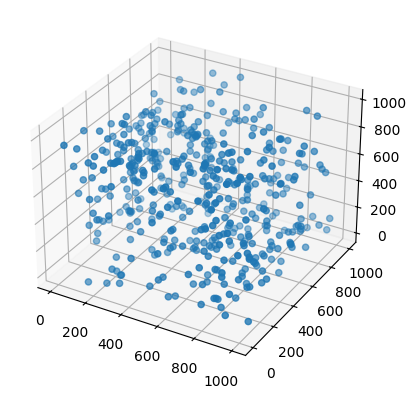

In [4]:
coords = halos[0, :500, :3]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2])

In [5]:
halo_pos_mean = halos[..., :3].mean((0,1))
halo_pos_std = halos[..., :3].std((0,1))
halo_pos = (halos[..., :3] - halo_pos_mean)  / halo_pos_std
halo_pos_test = (halos_test[..., :3] - halo_pos_mean)  / halo_pos_std

In [6]:
halo_all_mean = halos[..., :6].mean((0,1))
halo_all_std = halos[..., :6].std((0,1))
halo_all = (halos[..., :6] - halo_all_mean)  / halo_all_std
halo_all_test = (halos_test[..., :6] - halo_all_mean)  / halo_all_std

In [7]:
ones = np.ones((1600, 5000, 3))
ones_test = np.ones((200, 5000, 3))
# halo_ones = np.concatenate([halos[..., :3], ones], axis = -1)
# halo_ones_test = np.concatenate([halos_test[..., :3], ones_test], axis = -1)

# halo_ones_mean = halo_ones.mean((0,1))
# halo_ones_std = halo_ones.std((0,1))
# halo_ones = (halo_ones - halo_ones_mean)  / halo_ones_std
# halo_ones_test = (halo_ones_test - halo_ones_mean)  / halo_ones_std

halo_ones = np.concatenate([halo_pos, ones], axis = -1)
halo_ones_test = np.concatenate([halo_pos_test, ones_test], axis = -1)

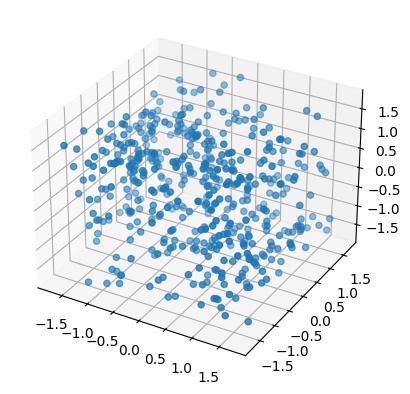

In [8]:
coords = halo_pos[0, :500, :3]

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2])

In [9]:
cosmology = pd.read_csv(data_dir / f'train_cosmology.csv')
cosmology_test = pd.read_csv(data_dir / f'test_cosmology.csv')
print(len(cosmology))

1600


In [10]:
cosmology.head(3)

,Omega_m,Omega_b,h,n_s,sigma_8
0,0.1755,0.06681,0.7737,0.8849,0.6641
1,0.2139,0.05557,0.8599,0.9785,0.8619
2,0.1867,0.04503,0.6189,0.8307,0.7187


In [11]:
omega_m = np.array(cosmology['Omega_m'].values)[:,None]
omega_m_test = np.array(cosmology_test['Omega_m'].values)[:,None]

## Experiments

### 2PCF

In [26]:
from tqdm.notebook import tqdm
from pycorr import TwoPointCorrelationFunction # Can install it here https://github.com/cosmodesi/pycorr

r_bins = np.linspace(0.5, 150.0, 25)
r_c = 0.5*(r_bins[1:] + r_bins[:-1])
mu_bins = np.linspace(-1, 1, 201)
box_size = 1000.

tpcfs = []
for halo in halos:
    tpcfs.append(
        TwoPointCorrelationFunction(
                "smu",
                edges=(np.array(r_bins), np.array(mu_bins)),
                data_positions1=np.array(halo[:,:3]).T,
                engine="corrfunc",
                n_threads=2,
                boxsize=box_size,
                los="z",
            )(ells=[0])[0]
    )
tpcfs = np.stack(tpcfs)

/n/home07/jballa/.conda/envs/jupyter_py3.11/lib/python3.11/site-packages/pycorr/corrfunc.py:147: UserWarning: These arguments are not read: {'n_threads': 2}
  warnings.warn('These arguments are not read: {}'.format(attrs))


In [27]:
print(tpcfs.shape)

(1600, 24)


In [27]:
print(r_c[-1])

146.8854


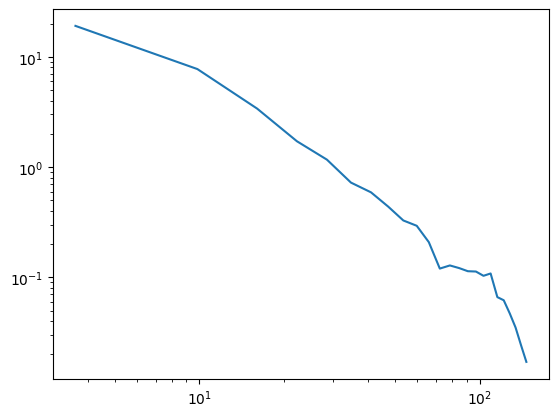

In [15]:
# This is how one of the tpcfs looks like
plt.loglog(
    r_c, tpcfs[2]
)
# It tells you how likely it is to find a pair of galaxies at a given pair separation r

In [21]:
test_tpcfs = []
for halo in halos_test:
    test_tpcfs.append(
        TwoPointCorrelationFunction(
                "smu",
                edges=(np.array(r_bins), np.array(mu_bins)),
                data_positions1=np.array(halo[:,:3]).T,
                engine="corrfunc",
                n_threads=2,
                boxsize=box_size,
                los="z",
            )(ells=[0])[0]
    )
    
test_tpcfs = np.stack(test_tpcfs)

In [16]:
import flax.linen as nn
import optax
from tqdm import trange

# let's build a simple flax model that can process these tpcfs
from typing import Sequence, Callable


class MLP(nn.Module):
    """A simple MLP."""

    feature_sizes: Sequence[int]
    activation: Callable[[np.ndarray], np.ndarray] = nn.gelu

    @nn.compact
    def __call__(self, x):
        for features in self.feature_sizes[:-1]:
            x = nn.Dense(features)(x)
            x = self.activation(x)

        # No activation on final layer
        x = nn.Dense(self.feature_sizes[-1])(x)
        return x

In [19]:
mlp = MLP(feature_sizes=[128,128,128, 1])
# and let's intialize some parameters for it by using an example input
key = jax.random.PRNGKey(0)
params = mlp.init(key, tpcfs[:3])

def loss_fn(params, x_batch, cosmo_batch,):
    pred_cosmo = mlp.apply(params, x_batch)
    return np.mean(pred_cosmo - cosmo_batch)**2

opt = optax.adamw(learning_rate=1e-2, weight_decay=1e-4)
opt_state = opt.init(params)

n_steps = 500 
n_batch = 32

with trange(n_steps) as steps:
    for step in steps:
        key, subkey = jax.random.split(key)
        idx = jax.random.choice(key, tpcfs.shape[0], shape=(n_batch,))
        
        tpcf_batch, cosmo_batch = tpcfs[idx], omega_m[idx]
        loss, grads = jax.value_and_grad(loss_fn)(params, tpcf_batch, cosmo_batch)
        updates, opt_state = opt.update(grads, opt_state, params)

        params = optax.apply_updates(params, updates)

        steps.set_postfix(loss=loss)

100%|██████████| 500/500 [00:36<00:00, 13.82it/s, loss=2.9945686e-05] 


Test Loss: 0.00023541914


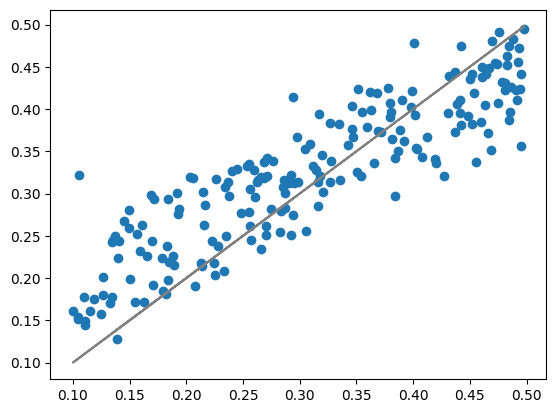

In [24]:
omega_m_pred = mlp.apply(params, test_tpcfs)

plt.scatter(omega_m_test, omega_m_pred[:,0])
plt.plot(omega_m_test, omega_m_test, color='gray')

print('Test Loss:', np.mean(omega_m_pred[:,0] - omega_m_test)**2)

### GNNs

In [12]:
import flax
from flax.training.train_state import TrainState
from functools import partial
import flax.linen as nn
import optax
from tqdm import trange
from utils.graph_utils import build_graph

replicate = flax.jax_utils.replicate
unreplicate = flax.jax_utils.unreplicate

In [13]:
from models.deepsets import DeepSets
from models.gnn import GNN
from models.egnn import EGNN
from typing import Dict

from models.equivariant_transformer import EquivariantTransformer
import e3nn_jax as e3nn


class GraphWrapper(nn.Module):
    model_name: str
    param_dict: Dict
    
    @nn.compact
    def __call__(self, x):
        if self.model_name == 'DeepSets':
            return jax.vmap(DeepSets(**self.param_dict))(x)
        elif self.model_name == 'GNN':
            return jax.vmap(GNN(**self.param_dict))(x)
        elif self.model_name == 'EGNN':
            return jax.vmap(EGNN(**self.param_dict))(x)
        elif self.model_name == 'EquivariantTransformer':
            pos = e3nn.IrrepsArray("1o", x.nodes[..., :3])
            feat = e3nn.IrrepsArray("1o", x.nodes[..., 3:])
            
            # feat = e3nn.IrrepsArray("1x0e", x.nodes[..., 3:])

            return jax.vmap(EquivariantTransformer(irreps_out="16x1o + 16x0e", d_hidden=64))(pos, feat, x.senders, x.receivers,)
        else:
            raise ValueError('Please specify a valid model name.')

In [14]:
from tqdm import tqdm
from IPython.display import display, clear_output

def loss_mse(pred_batch, cosmo_batch,):
        return np.mean((pred_batch - cosmo_batch) ** 2)

@partial(jax.pmap, axis_name="batch",)
def train_step(state, halo_batch, cosmo_batch):

    # Build graph
    halo_graph = build_graph(halo_batch, k=20, use_pbc=True, use_edges=False)
    
    def loss_fn(params):
        outputs, node_reps = state.apply_fn(params, halo_graph)
        
        loss = loss_mse(outputs, cosmo_batch)
        return loss

    # Get loss, grads, and update state
    loss, grads = jax.value_and_grad(loss_fn)(state.params)
    grads = jax.lax.pmean(grads, "batch")
    new_state = state.apply_gradients(grads=grads)
    metrics = {"loss": jax.lax.pmean(loss, "batch")}
    
    outputs, node_reps = state.apply_fn(state.params, halo_graph)
    
    return new_state, metrics, node_reps

@partial(jax.pmap, axis_name="batch",)
def test_step(state, halo_batch, cosmo_batch):

    # Build graph
    halo_graph = build_graph(halo_batch, k=20, use_pbc=True, use_edges=False)
    
    outputs, node_reps = state.apply_fn(state.params, halo_graph)
    loss = loss_mse(outputs, cosmo_batch)
    
    return outputs, {"loss": jax.lax.pmean(loss, "batch")}, node_reps

def run_expt(model_name,
             dataset,
             param_dict, 
             k = 20, 
             use_pbc = True, 
             use_edges = False, 
             n_steps = 1000,
             n_batch = 32,
             n_train = 1600,
             n_test_batch = 32,
             learning_rate=5e-5, 
             weight_decay=1e-5,
             eval_every=200,
             get_node_reps=False):
    # Initialize model
    if dataset == 'pos':
        halo, halo_test = halo_pos, halo_pos_test
    elif dataset == 'all':
        halo, halo_test = halo_all, halo_all_test
    else:
        halo, halo_test = halo_ones, halo_ones_test
    graph = build_graph(halo[:2], k=k, use_pbc=use_pbc, use_edges=use_edges)
    
    if get_node_reps:
        param_dict['get_node_reps'] = True
    
    model = GraphWrapper(model_name, param_dict)

    key = jax.random.PRNGKey(0)
    out, params = model.init_with_output(key, graph)
    
    print(out)
    
    # Define train state and replicate across devices
    num_local_devices = jax.local_device_count()
    tx = optax.adamw(learning_rate=learning_rate, weight_decay=weight_decay)
    state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
    pstate = replicate(state)
    
    key = jax.random.PRNGKey(0)

    # Run training loop
    print('Training...')
    losses = []
    test_losses = []
    # n_test_batches = len(halo_pos_test) // n_test_batch
    curr_loss, curr_test_loss, curr_preds = None, None, None
    node_rep_list = []
    
    with trange(n_steps) as steps:
        for step in steps:
            key, subkey = jax.random.split(key)
            idx = jax.random.choice(key, halo.shape[0], shape=(n_batch,))

            halo_batch, cosmo_batch = halo[:n_train][idx], omega_m[:n_train][idx]
            # halo_batch, cosmo_batch = halo_pos[:n_batch], omega_m[:n_batch]  # Overfit on a small sample

            # Split batches across devices
            halo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_batch)
            cosmo_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), cosmo_batch)
            halo_batch, cosmo_batch = np.array(halo_batch), np.array(cosmo_batch)

            pstate, metrics, node_reps = train_step(pstate, halo_batch, cosmo_batch)
            curr_loss = unreplicate(metrics["loss"])
            
            if step % eval_every == 0:
                halo_test_batch, cosmo_test_batch = halo_test, omega_m_test
                # Split batches across devices
                halo_test_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), halo_test_batch)
                cosmo_test_batch = jax.tree_map(lambda x: np.split(x, num_local_devices, axis=0), cosmo_test_batch)
                halo_test_batch, cosmo_test_batch = np.array(halo_test_batch), np.array(cosmo_test_batch)

                outputs, test_metrics, node_reps = test_step(pstate, halo_test_batch, cosmo_test_batch)
                curr_test_loss = unreplicate(test_metrics["loss"])
                outputs = np.reshape(outputs, (num_local_devices*outputs.shape[1], outputs.shape[-1]))
           
                plt.clf()
                plt.scatter(np.vstack(cosmo_test_batch), outputs, color='firebrick')
                plt.plot(np.vstack(cosmo_test_batch), np.vstack(cosmo_test_batch), color='gray')
                
                clear_output(wait=True)
                display(plt.gcf())
                
                curr_preds = outputs
                node_rep_list.append(node_reps)
                
            steps.set_postfix(loss=curr_loss, test_loss=curr_test_loss)
            losses.append(curr_loss)
            test_losses.append(curr_test_loss)
                # print('Train loss: {}, Test loss: {}'.format(sum(metrics["loss"])/len(metrics["loss"]), sum(test_metrics["loss"])/len(test_metrics["loss"])))
          
#     Evaluate
#     print('Evaluating...')
#     if evaluate:
#     n_test_batches = len(halo_pos_test) // n_test_batch
#     omega_m_preds = []
#     node_rep_list = []
#     for i in tqdm(range(n_test_batches)):

#         # TODO: jit/pmap
#         graph = build_graph(halo_pos_test[i * n_test_batch:(i + 1) * n_test_batch], k=k, use_pbc=use_pbc, use_edges=use_edges)
#         omega_m_pred, node_reps = jax.jit(model.apply)(unreplicate(pstate).params, graph)
#         omega_m_preds.append(omega_m_pred)
#         node_rep_list.append(node_reps)
#         plt.scatter(omega_m_test[i * n_test_batch:(i + 1) * n_test_batch], omega_m_pred[:, 0], s=10, color='firebrick')
#         print(loss_mse(omega_m_pred, omega_m_test[i * n_test_batch:(i + 1) * n_test_batch]))

#     plt.plot(omega_m_test[:n_test_batch], omega_m_test[:n_test_batch], color='gray')

#     plt.xlabel("True")
#     plt.ylabel("Predicted")
#     plt.show()

    plt.close()
        
    # print('Final train loss: {}, Average test loss: {}'.format(losses[-1], sum(test_losses)/len(test_losses))
    return losses, test_losses, curr_preds, node_rep_list

In [71]:
from importlib import reload 
import models
reload(models)
from models.deepsets import DeepSets
from models.gnn import GNN
from models.egnn import EGNN
from models.equivariant_transformer import EquivariantTransformer

### DeepSets

#### Positions only

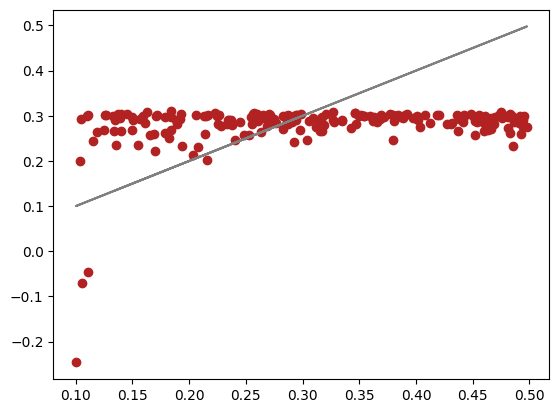

100%|██████████| 2000/2000 [06:52<00:00,  4.84it/s, loss=0.012315923, test_loss=0.01431194] 


In [22]:
deepsets_default_params = {
    'n_outputs': 1,
    'message_passing_steps': 6,
    'n_layers': 3,
    'd_hidden': 64,
    'activation': 'gelu',
    'message_passing_agg': 'mean',
    'readout_agg': "mean",
    'readout_only_positions': False,
    'task': "graph",
    'mlp_readout_widths': [64, 128, 64, 8]
}
deepsets_losses, deepsets_test_losses, deepsets_preds, node_rep_list = run_expt("DeepSets", "pos", deepsets_default_params, learning_rate=1e-4, weight_decay=1e-5, n_steps=2000, n_batch=256)

In [46]:
np.save('deepsets_node_rep_list.npy', np.array(node_rep_list))

In [47]:
embedding_list = []
for node_reps in node_rep_list:
    np_node_reps = np.array(np.vstack(node_reps)[:, 0, :])
    embeddings = TSNE().fit_transform(np_node_reps)
    embedding_list.append(embeddings)

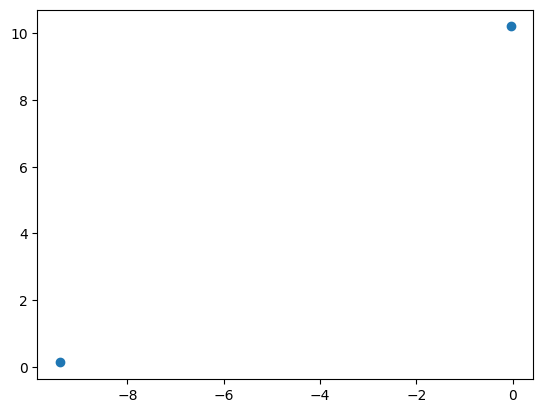

In [49]:
i = 0
plt.scatter(embedding_list[i][0], embedding_list[i][1])

In [33]:
np_node_reps = np.array(np.vstack(node_rep_list)[:, 0, :])
np.save('deepsets_node_reps.npy', np_node_reps)

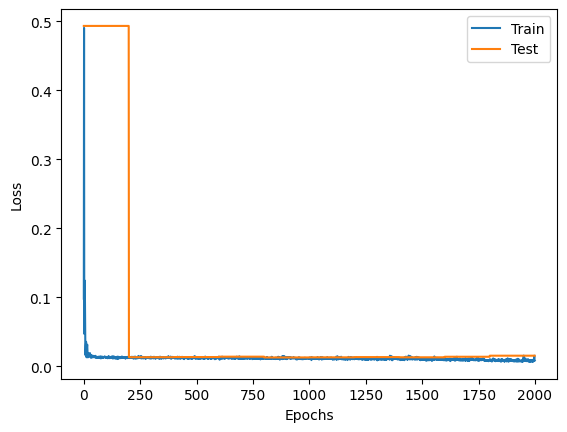

In [34]:
plt.plot(deepsets_losses, label='Train')
plt.plot(deepsets_test_losses, label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

#### Positions + Velocity

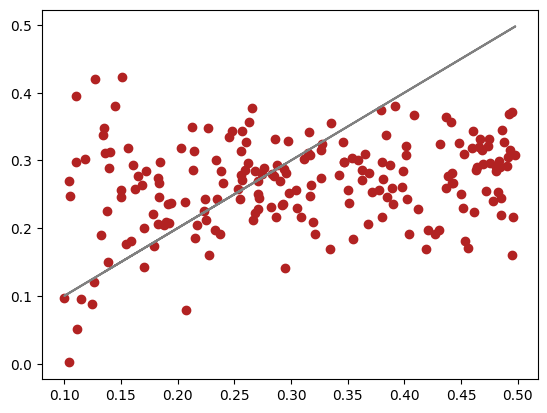

100%|██████████| 2000/2000 [06:50<00:00,  4.87it/s, loss=0.007968481, test_loss=0.016474117] 


In [23]:
deepsets_default_params = {
    'n_outputs': 1,
    'message_passing_steps': 6,
    'n_layers': 3,
    'd_hidden': 64,
    'activation': 'gelu',
    'message_passing_agg': 'mean',
    'readout_agg': "mean",
    'readout_only_positions': False,
    'task': "graph",
    'mlp_readout_widths': [64, 128, 64, 8]
}
deepsets_losses, deepsets_test_losses, deepsets_preds, node_rep_list = run_expt("DeepSets", "all", deepsets_default_params, learning_rate=1e-4, weight_decay=1e-5, n_steps=2000, n_batch=256)

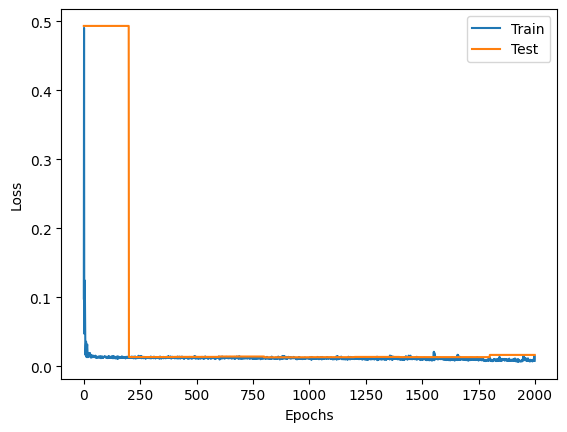

In [24]:
plt.plot(deepsets_losses, label='Train')
plt.plot(deepsets_test_losses, label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### GNN

#### Positions only

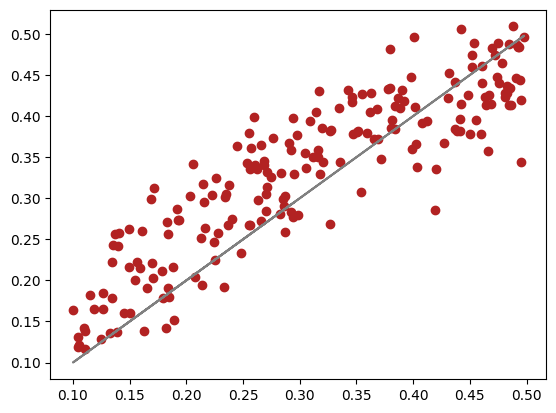

100%|██████████| 2000/2000 [05:58<00:00,  5.59it/s, loss=0.0032680542, test_loss=0.003617248]


In [20]:
gnn_default_params = {
    'n_outputs': 1,
    'message_passing_steps': 6,
    'n_layers': 3,
    'd_hidden': 64,
    'activation': 'gelu',
    'message_passing_agg': 'mean',
    'readout_agg': "mean",
    'readout_only_positions': False,
    'task': "graph",
    'mlp_readout_widths': [8, 2],
    'norm': 'layer'
} 

gnn_losses, gnn_test_losses, gnn_preds, node_rep_list = run_expt("GNN", "pos", gnn_default_params, learning_rate=1e-4, weight_decay=1e-5, n_steps=2000, n_batch=32)

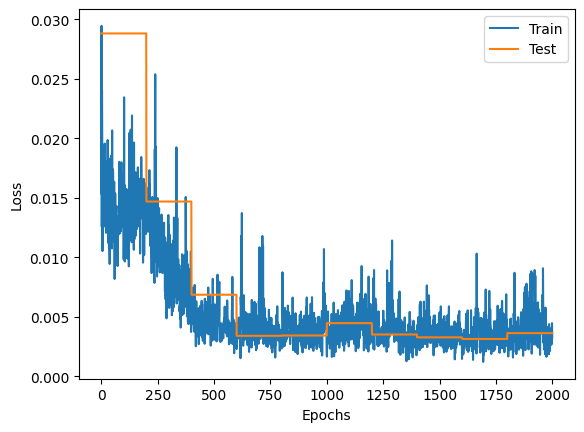

In [21]:
plt.plot(gnn_losses, label='Train')
plt.plot(gnn_test_losses, label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

#### Positions + velocities

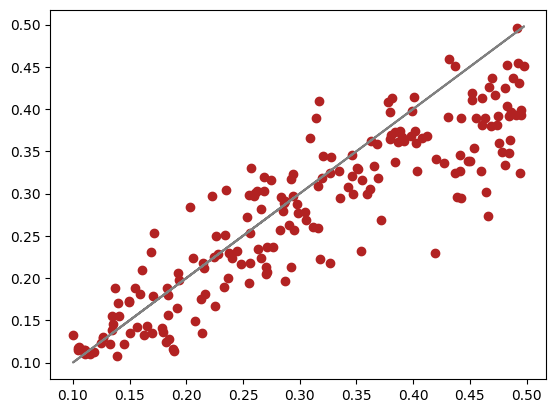

100%|██████████| 2000/2000 [05:54<00:00,  5.63it/s, loss=0.0035930118, test_loss=0.0036954032]


In [18]:
gnn_default_params = {
    'n_outputs': 1,
    'message_passing_steps': 6,
    'n_layers': 3,
    'd_hidden': 64,
    'activation': 'gelu',
    'message_passing_agg': 'mean',
    'readout_agg': "mean",
    'readout_only_positions': False,
    'task': "graph",
    'mlp_readout_widths': [8, 2],
    'norm': 'layer'
} 

gnn_losses, gnn_test_losses, gnn_preds, node_rep_list = run_expt("GNN", "all", gnn_default_params, learning_rate=1e-4, weight_decay=1e-5, n_steps=2000, n_batch=32)

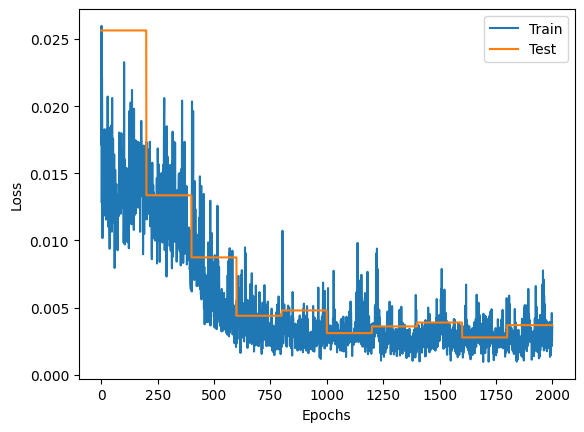

In [19]:
plt.plot(gnn_losses, label='Train')
plt.plot(gnn_test_losses, label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

Now use edge features

In [ ]:
gnn_default_params = {
    'n_outputs': 1,
    'message_passing_steps': 6,
    'n_layers': 3,
    'd_hidden': 64,
    'activation': 'gelu',
    'message_passing_agg': 'mean',
    'readout_agg': "mean",
    'readout_only_positions': False,
    'task': "graph",
    'mlp_readout_widths': [8, 2],
    'norm': 'layer'
} 

gnn_with_edges_losses, gnn_with_edges_test_losses, gnn_with_edges_preds = run_expt("GNN", gnn_default_params, learning_rate=1e-4, weight_decay=1e-5, n_steps=2000, n_batch=32, use_edges=True)

### EGNN

#### Positions only

In [72]:
egnn_default_params = {
    'n_outputs': 1,
    'message_passing_steps': 6,
    'n_layers': 3,
    'd_hidden': 64,
    'activation': 'gelu',
    'message_passing_agg': 'mean',
    'readout_agg': "mean",
    'readout_only_positions': False,
    'task': "graph",
    'mlp_readout_widths': [8, 2],
    'use_fourier_features': False,
    'tanh_out': False, 
    'soft_edges': True,
    'decouple_pos_vel_updates': True,
    'normalize_messages': True,
    'positions_only': True
}

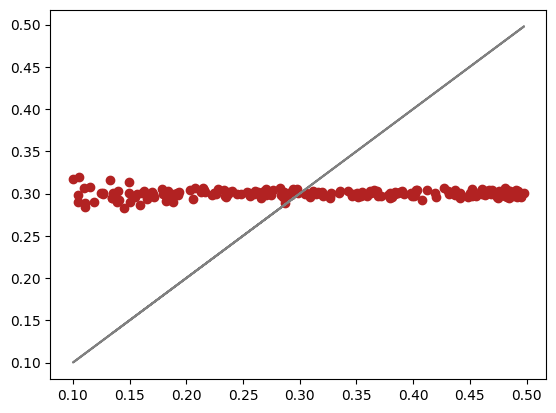

100%|██████████| 5000/5000 [14:57<00:00,  5.57it/s, loss=0.0160799, test_loss=0.013916832]   


In [73]:
egnn_losses, egnn_test_losses, egnn_preds, node_rep_list = run_expt("EGNN", "pos", egnn_default_params, learning_rate=5e-5, weight_decay=1e-5, n_steps=5000, n_batch=32)

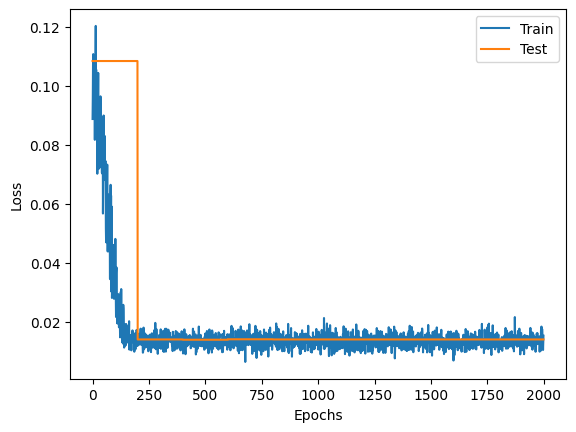

In [24]:
plt.plot(egnn_losses, label='Train')
plt.plot(egnn_test_losses, label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [19]:
np.save('egnn_node_rep_list.npy', np.array(node_rep_list))

##### Without PBC

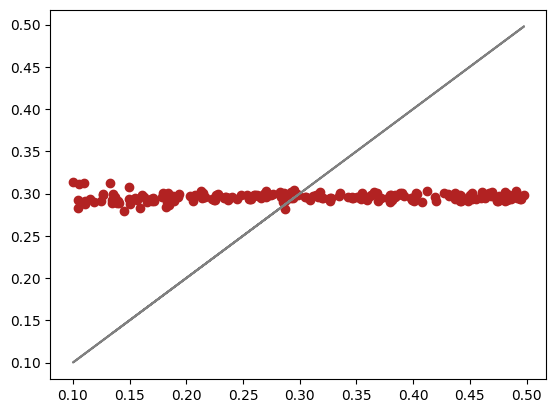

100%|██████████| 2000/2000 [05:53<00:00,  5.67it/s, loss=0.015220212, test_loss=0.013945161] 


In [23]:
egnn_losses, egnn_test_losses, egnn_preds, node_rep_list = run_expt("EGNN", "pos", egnn_default_params, learning_rate=5e-5, weight_decay=1e-5, n_steps=2000, n_batch=32)

#### Positions + velocities

In [ ]:
egnn_default_params = {
    'n_outputs': 1,
    'message_passing_steps': 6,
    'n_layers': 4,
    'd_hidden': 64,
    'activation': 'gelu',
    'message_passing_agg': 'mean',
    'readout_agg': "mean",
    'readout_only_positions': False,
    'task': "graph",
    'mlp_readout_widths': [8, 2],
    'use_fourier_features': False,
    'tanh_out': False, 
    'soft_edges': True,
    'decouple_pos_vel_updates': True,
    'normalize_messages': True,
    'positions_only': False
}

egnn_losses, egnn_test_losses, egnn_preds, node_rep_list = run_expt("EGNN", "all", egnn_default_params, learning_rate=5e-5, weight_decay=1e-5, n_steps=5000, n_batch=32)

(Array([[-2.2115324e-05],
       [-3.6859157e-05]], dtype=float32), Array([[[ 1.6383639e-06, -1.3239370e-06,  1.3937836e-06, ...,
          2.3043840e-05,  3.8108799e-05, -4.3175325e-05],
        [ 3.4895558e-07, -3.0823371e-06,  5.3081902e-07, ...,
          2.6978099e-05,  4.4593693e-05, -5.0525297e-05],
        [ 1.6255656e-06,  3.3978995e-06,  2.1295600e-06, ...,
          2.8969949e-05,  4.7889884e-05, -5.4258708e-05],
        ...,
        [ 9.5233378e-07, -1.3923606e-06, -1.3777226e-06, ...,
          2.9242732e-05,  4.8333975e-05, -5.4749864e-05],
        [ 1.9036606e-06, -1.3624594e-06, -3.0498424e-07, ...,
          3.1190077e-05,  5.1545390e-05, -5.8371552e-05],
        [ 1.4174125e-06, -7.5755310e-07,  2.4510808e-07, ...,
          2.2496815e-05,  3.7197478e-05, -4.2143773e-05]],

       [[ 1.7016911e-08, -4.5984316e-06,  3.0158972e-06, ...,
          3.5156310e-05,  5.8092883e-05, -6.5791028e-05],
        [-5.3362066e-07,  2.1995737e-07,  7.5127156e-07, ...,
          2.492

  0%|          | 0/5000 [00:00<?, ?it/s]

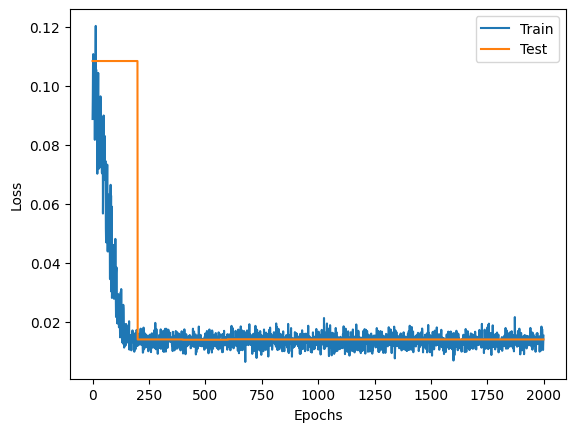

In [14]:
plt.plot(egnn_losses, label='Train')
plt.plot(egnn_test_losses, label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

##### Without PBC

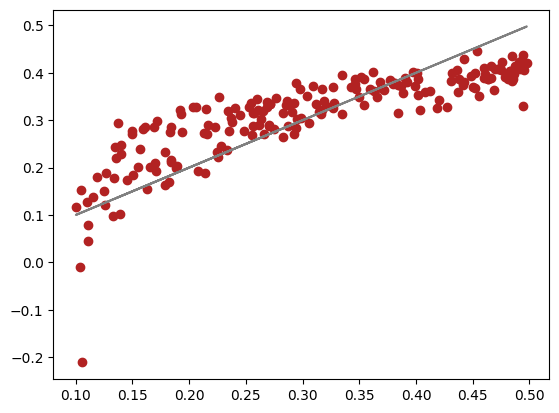

100%|██████████| 5000/5000 [19:44<00:00,  4.22it/s, loss=0.0040666377, test_loss=0.0043924255]


In [69]:
egnn_default_params = {
    'n_outputs': 1,
    'message_passing_steps': 6,
    'n_layers': 4,
    'd_hidden': 64,
    'activation': 'gelu',
    'message_passing_agg': 'mean',
    'readout_agg': "mean",
    'readout_only_positions': False,
    'task': "graph",
    'mlp_readout_widths': [8, 2],
    'use_fourier_features': False,
    'tanh_out': False, 
    'soft_edges': True,
    'decouple_pos_vel_updates': True,
    'normalize_messages': True,
    'positions_only': False
}

egnn_losses, egnn_test_losses, egnn_preds, node_rep_list = run_expt("EGNN", "all", egnn_default_params, learning_rate=5e-5, weight_decay=1e-5, n_steps=5000, n_batch=32)

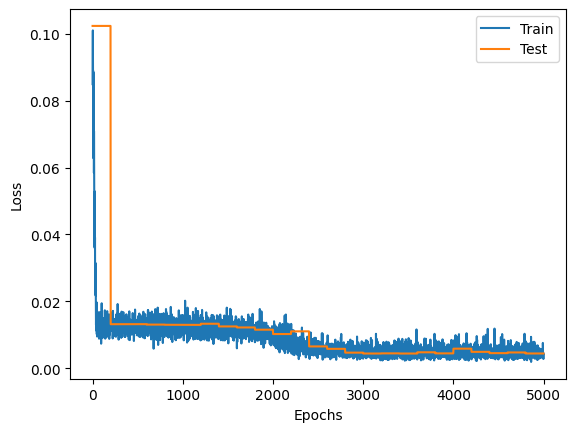

In [70]:
plt.plot(egnn_losses, label='Train')
plt.plot(egnn_test_losses, label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

### Equivariant Transformer

In [66]:
equivariant_transformer_default_params = {
    'n_outputs': 1,
    'n_layers': 4,
    'd_hidden': 64,
    'activation': 'gelu',
    'readout_agg': "mean",
    'readout_only_positions': False,
    'task': "graph",
    'mlp_readout_widths': [8, 2],
    'num_heads': 1,
}

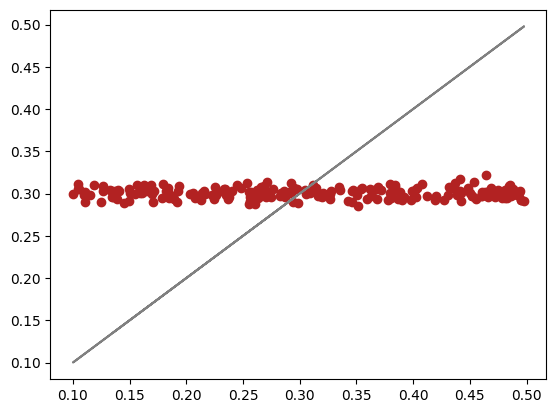

100%|██████████| 5000/5000 [10:32<00:00,  7.90it/s, loss=0.017135162, test_loss=0.013982836] 


In [67]:
equivariant_transformer_losses, equivariant_transformer_test_losses, equivariant_transformer_preds, node_rep_list = run_expt("EquivariantTransformer", "ones", equivariant_transformer_default_params, learning_rate=5e-5, weight_decay=1e-5, n_steps=5000, n_batch=32)

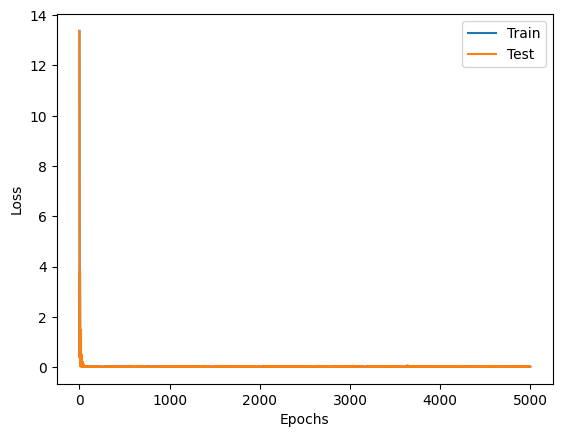

In [68]:
plt.plot(equivariant_transformer_losses, label='Train')
plt.plot(equivariant_transformer_losses, label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

#### Positions + Velocities

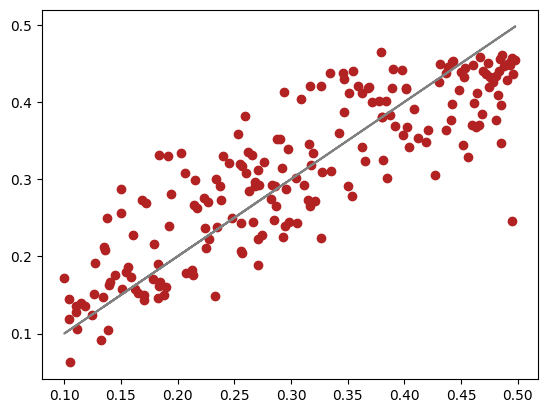

100%|██████████| 5000/5000 [10:32<00:00,  7.90it/s, loss=0.003605841, test_loss=0.00367998]   


In [17]:
equivariant_transformer_losses, equivariant_transformer_test_losses, equivariant_transformer_preds, node_rep_list = run_expt("EquivariantTransformer", "all", equivariant_transformer_default_params, learning_rate=5e-5, weight_decay=1e-5, n_steps=5000, n_batch=32)

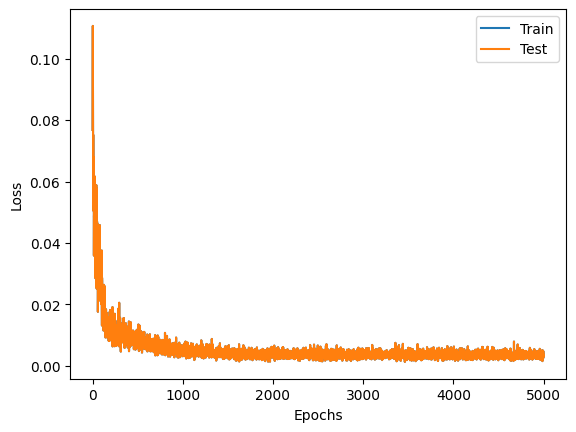

In [18]:
plt.plot(equivariant_transformer_losses, label='Train')
plt.plot(equivariant_transformer_losses, label='Test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()